In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input,GlobalMaxPool1D,Dropout
from keras.utils import plot_model

import nltk
import re
from nltk.corpus import stopwords #corpus is collection of text
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score

In [39]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [40]:
# Load train data
df = pd.read_csv('data.csv')

print(df.shape)
df.head()

(20800, 5)


,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [41]:
df10=df[:7000]
print(df10.shape)

(7000, 5)


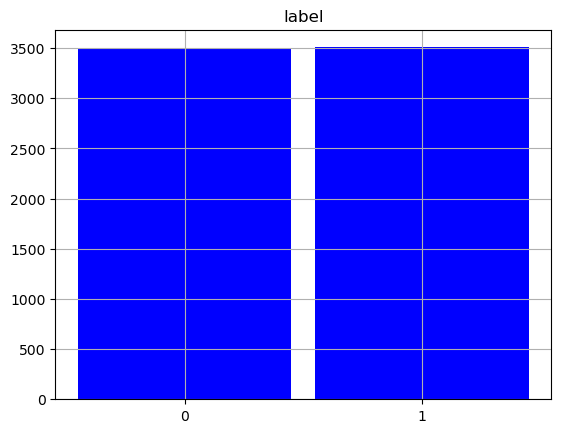

In [42]:
# Class balance analysis
df10[['label']].hist(bins = 3)
plt.bar(np.arange(len([0,1])), df10.groupby(['label']).size().values, 0.9,  color="blue")
plt.xticks(np.arange(len([0,1])), [0,1])
plt.show()

In [43]:
df0 = df10

In [44]:
print("Number of missing values in each column:")
print(df0.isnull().sum())
print("We drop the missing values")
df0= df0.dropna()
print("The shape of the dataset is now: ", df0.shape)
print(df0.isnull().sum())

Number of missing values in each column:
id          0
title     193
author    670
text       14
label       0
dtype: int64
We drop the missing values
The shape of the dataset is now:  (6137, 5)
id        0
title     0
author    0
text      0
label     0
dtype: int64


In [45]:
y=df0['label']
X=df0.drop('label',axis=1)


In [46]:
vo_size=500
messages=X.copy()
messages.reset_index(inplace=True)

In [47]:
ps =PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    print("Status: %s / %s" %(i, len(messages)), end="\r")
    review = re.sub('[^a-zA-Z]', ' ',messages['text'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [48]:
# one hot representation
onehot_rep = [one_hot(words, vo_size) for words in corpus]

In [49]:
sent_length = 1000
embedded_doc=pad_sequences(onehot_rep, padding='pre', maxlen=sent_length)
print(embedded_doc)

[[  0   0   0 ... 314 377 322]
 [  0   0   0 ... 155  98 295]
 [  0   0   0 ... 218 470  67]
 ...
 [  0   0   0 ... 427  85 397]
 [  0   0   0 ... 482 155  32]
 [  0   0   0 ...  77 182 261]]


In [50]:
X_final=np.array(embedded_doc)
y_final=np.array(y)
X_final.shape,y_final.shape

((6137, 1000), (6137,))

In [51]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [52]:
from numpy import asarray
from numpy import zeros
# load the whole embedding into memory
embeddings_index = dict()
f = open('glove.6B.50d.txt', encoding="utf8")
for line in f:
 values = line.split()
 word = values[0]
 coefs = np.asarray(values[1:], dtype='float32')
 embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [53]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
# create a weight matrix for words in training docs
embedding_matrix = zeros((vo_size, 50))
for word, i in tokenizer.word_index.items():
     embedding_vector = embeddings_index.get(word)
     if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [54]:
X_train, X_temp, y_train, y_temp = train_test_split(X_final, y_final, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [55]:
from keras.layers import Activation, SimpleRNN
from tensorflow.keras.layers import Bidirectional
#rnn_model = Sequential()
#rnn_model.add(Embedding(vocab_size, 128, input_length=max_sequence_length))
#rnn_model.add(Embedding(vo_size,embedding_vector_feature,input_length=sent_length))
#rnn_model.add(SimpleRNN(200, dropout=0.2, recurrent_dropout=0.2))
#rnn_model.add(Dense(1, activation='sigmoid'))


rnn_model = Sequential()
rnn_model.add(Embedding(vo_size, 100, input_length=sent_length))
rnn_model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
rnn_model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.30, activation='tanh', return_sequences=True)))
rnn_model.add(SimpleRNN(32, activation='tanh'))
rnn_model.add(Dropout(0.2))
rnn_model.add(Dense(1, activation='sigmoid'))
rnn_model.summary()



rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

rnn_model.fit(X_final,y_final, epochs=10, batch_size=256, validation_data=(X_val, y_val))
#rnn_accuracy = rnn_model.evaluate(test_sequences, test_labels)[1]


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 100)         50000     
                                                                 
 bidirectional (Bidirectiona  (None, 1000, 128)        21120     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 1000, 128)        24704     
 nal)                                                            
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 32)                5152      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 3

In [56]:
rnn_loss, rnn_accuracy = rnn_model.evaluate(X_test, y_test)
print("Test Loss:", rnn_loss)
print("Test Accuracy:", rnn_accuracy)

29/29 [==============================] - 5s 173ms/step - loss: 0.4390 - accuracy: 0.7948
Test Loss: 0.4390315115451813
Test Accuracy: 0.7947883009910583


In [57]:
# lstm model 1 build 
embedding_vector_feature = 100
lstm_model=Sequential()
lstm_model.add(Embedding(vo_size,embedding_vector_feature,input_length=sent_length))
lstm_model.add(LSTM(200))
lstm_model.add(Dense(1,activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(lstm_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 100)         50000     
                                                                 
 lstm (LSTM)                 (None, 200)               240800    
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 291,001
Trainable params: 291,001
Non-trainable params: 0
_________________________________________________________________
None


In [58]:
history = lstm_model.fit(X_final,y_final, epochs=10, batch_size=256, validation_data=(X_val, y_val))

Epoch 1/10
24/24 [==============================] - 431s 18s/step - loss: 0.6610 - accuracy: 0.6441 - val_loss: 0.6005 - val_accuracy: 0.7872
Epoch 2/10
24/24 [==============================] - 427s 18s/step - loss: 0.4824 - accuracy: 0.7864 - val_loss: 0.3860 - val_accuracy: 0.8371
Epoch 3/10
24/24 [==============================] - 426s 18s/step - loss: 0.3375 - accuracy: 0.8584 - val_loss: 0.2958 - val_accuracy: 0.8817
Epoch 4/10
24/24 [==============================] - 429s 18s/step - loss: 0.3398 - accuracy: 0.8533 - val_loss: 0.3658 - val_accuracy: 0.8219
Epoch 5/10
24/24 [==============================] - 431s 18s/step - loss: 0.3496 - accuracy: 0.8467 - val_loss: 0.2719 - val_accuracy: 0.8903
Epoch 6/10
24/24 [==============================] - 433s 18s/step - loss: 0.2790 - accuracy: 0.8863 - val_loss: 0.2410 - val_accuracy: 0.9077
Epoch 7/10
24/24 [==============================] - 435s 18s/step - loss: 0.2486 - accuracy: 0.9053 - val_loss: 0.2172 - val_accuracy: 0.9142
Epoch 

In [59]:
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test, y_test)
print("Test Loss:", lstm_loss)
print("Test Accuracy:", lstm_accuracy)

29/29 [==============================] - 37s 1s/step - loss: 0.2069 - accuracy: 0.9229
Test Loss: 0.20689333975315094
Test Accuracy: 0.9229098558425903


In [60]:
# Deeper lstm model build 
lstm2_model = Sequential()
lstm2_model.add(Embedding(vo_size,embedding_vector_feature,input_length=sent_length))
lstm2_model.add(LSTM(100, return_sequences=True,name='lstm_layer'))
lstm2_model.add(GlobalMaxPool1D())
lstm2_model.add(Dropout(0.1))
lstm2_model.add(Dense(50, activation='relu'))
lstm2_model.add(Dropout(0.1))
lstm2_model.add(Dense(1,activation='sigmoid'))
lstm2_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(lstm2_model.summary())
# Compile the model
#model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
batch_size = 256  # You can experiment with different batch sizes
epochs = 10  # You can experiment with different numbers of epochs
#history = model1.fit(X_final,y_final, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))
history = lstm2_model.fit(X_final,y_final, epochs=10, batch_size=256, validation_data=(X_val, y_val))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1000, 100)         50000     
                                                                 
 lstm_layer (LSTM)           (None, 1000, 100)         80400     
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                      

In [61]:
# Evaluate the model on the test set
lstm2_loss, lstm2_accuracy = lstm2_model.evaluate(X_test, y_test)
print("Test Loss:", lstm2_loss)
print("Test Accuracy:", lstm2_accuracy)

29/29 [==============================] - 10s 338ms/step - loss: 0.1847 - accuracy: 0.9370
Test Loss: 0.18474189937114716
Test Accuracy: 0.9370249509811401


In [62]:
from keras import layers
embedding_dim = 100

cnn_model = Sequential()

#cnn_model.add(layers.Embedding(vo_size, embedding_dim, weights=[embedding_matrix],input_length=sent_length,trainable=True))
cnn_model.add(layers.Embedding(vo_size, embedding_dim, input_length=sent_length))
cnn_model.add(layers.Conv1D(128, 5, activation='relu'))
cnn_model.add(layers.GlobalMaxPooling1D())
cnn_model.add(layers.Dense(10, activation='relu'))
cnn_model.add(layers.Dense(1, activation='sigmoid'))
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = cnn_model.fit(X_final,y_final, epochs=10, validation_data=(X_val, y_val), batch_size=256)

Epoch 1/10
24/24 [==============================] - 23s 934ms/step - loss: 0.6793 - accuracy: 0.5641 - val_loss: 0.6434 - val_accuracy: 0.6395
Epoch 2/10
24/24 [==============================] - 21s 873ms/step - loss: 0.5902 - accuracy: 0.7031 - val_loss: 0.5016 - val_accuracy: 0.7742
Epoch 3/10
24/24 [==============================] - 23s 959ms/step - loss: 0.4387 - accuracy: 0.8006 - val_loss: 0.3574 - val_accuracy: 0.8664
Epoch 4/10
24/24 [==============================] - 21s 900ms/step - loss: 0.3004 - accuracy: 0.8817 - val_loss: 0.2501 - val_accuracy: 0.9034
Epoch 5/10
24/24 [==============================] - 21s 882ms/step - loss: 0.2263 - accuracy: 0.9109 - val_loss: 0.1926 - val_accuracy: 0.9251
Epoch 6/10
24/24 [==============================] - 20s 840ms/step - loss: 0.1783 - accuracy: 0.9361 - val_loss: 0.1493 - val_accuracy: 0.9435
Epoch 7/10
24/24 [==============================] - 20s 817ms/step - loss: 0.1401 - accuracy: 0.9547 - val_loss: 0.1161 - val_accuracy: 0.9718

In [63]:
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test, y_test)
print("Test Loss:", cnn_loss)
print("Test Accuracy:", cnn_accuracy)

29/29 [==============================] - 1s 23ms/step - loss: 0.0502 - accuracy: 0.9924
Test Loss: 0.05015105754137039
Test Accuracy: 0.9923995733261108


In [64]:
print("RNN Model Accuracy:", rnn_accuracy)
print("LSTM Model Accuracy:", lstm_accuracy)
print("Deeper LSTM Model Accuracy:", lstm2_accuracy)
print("CNN Model Accuracy:", cnn_accuracy)


RNN Model Accuracy: 0.7947883009910583
LSTM Model Accuracy: 0.9229098558425903
Deeper LSTM Model Accuracy: 0.9370249509811401
CNN Model Accuracy: 0.9923995733261108


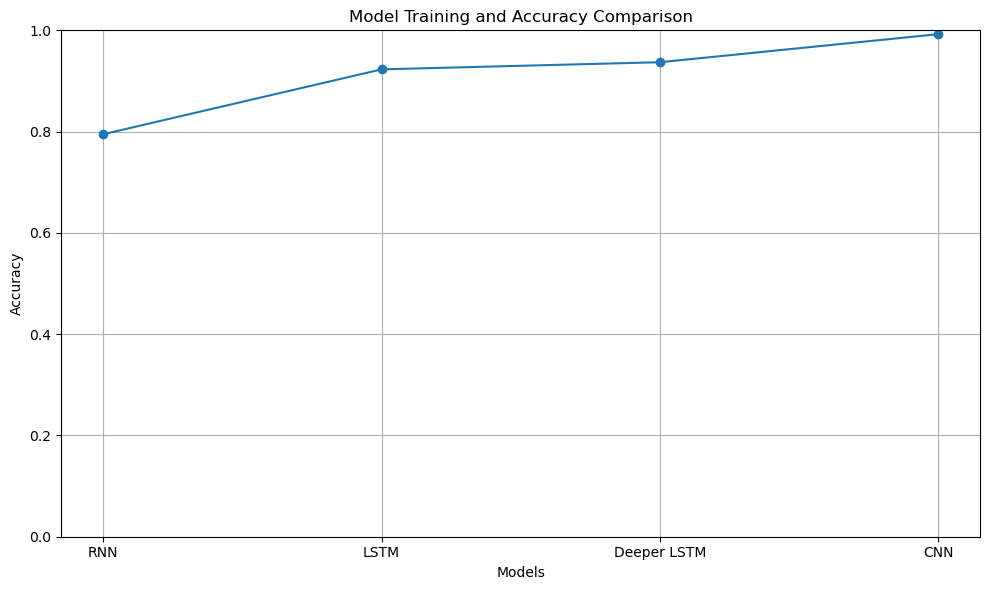

In [67]:
import matplotlib.pyplot as plt

# Define the model names and corresponding accuracies
model_names = ['RNN', 'LSTM', 'Deeper LSTM', 'CNN']
accuracies = [rnn_accuracy, lstm_accuracy, lstm2_accuracy, cnn_accuracy]

# Define the epochs or training iterations
epochs = range(1, len(accuracies) + 1)

# Plot the training and accuracy graph
plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracies, marker='o')
plt.title('Model Training and Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.xticks(epochs, model_names)
plt.grid(True)
plt.ylim(0, 1)  # Set the y-axis limits to be between 0 and 1 for accuracy percentage
plt.tight_layout()

# Display the graph
plt.show()


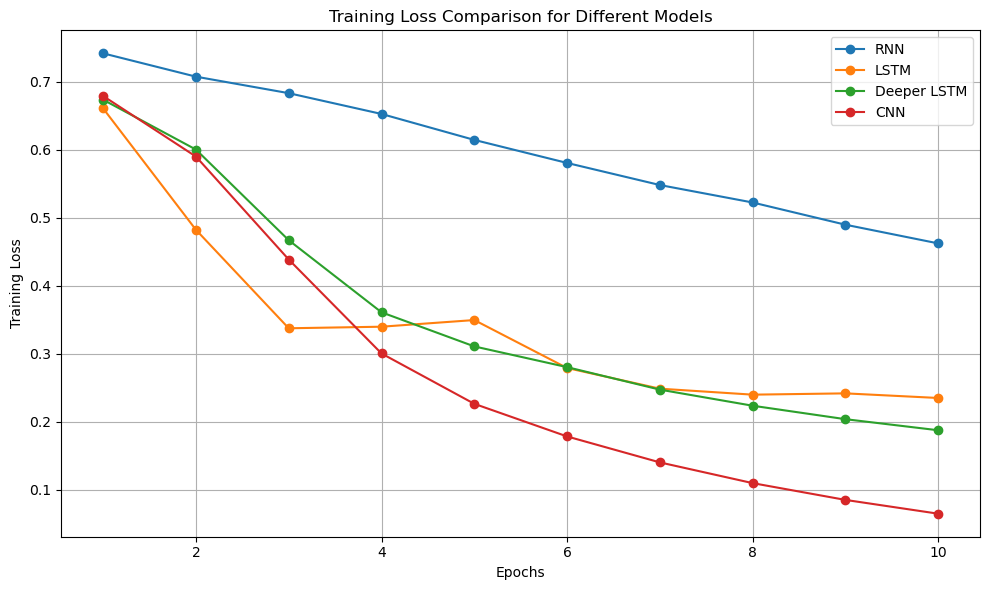

In [68]:
import matplotlib.pyplot as plt

# Training loss values for each epoch
rnn_train_loss = [0.7421, 0.7078, 0.6835, 0.6529, 0.6147, 0.5808, 0.5483, 0.5226, 0.4899, 0.4624]
lstm_train_loss = [0.6610, 0.4824, 0.3375, 0.3398, 0.3496, 0.2790, 0.2486, 0.2398, 0.2417, 0.2349]
lstm2_train_loss = [0.6738, 0.6005, 0.4671, 0.3610, 0.3108, 0.2803, 0.2472, 0.2235, 0.2037, 0.1874]
cnn_train_loss = [0.6793, 0.5902, 0.4387, 0.3004, 0.2263, 0.1783, 0.1401, 0.1096, 0.0849, 0.0646]

# Number of epochs
epochs = range(1, 11)

# Plot the training loss graphs
plt.figure(figsize=(10, 6))
plt.plot(epochs, rnn_train_loss, marker='o', label='RNN')
plt.plot(epochs, lstm_train_loss, marker='o', label='LSTM')
plt.plot(epochs, lstm2_train_loss, marker='o', label='Deeper LSTM')
plt.plot(epochs, cnn_train_loss, marker='o', label='CNN')
plt.title('Training Loss Comparison for Different Models')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Display the graph
plt.show()


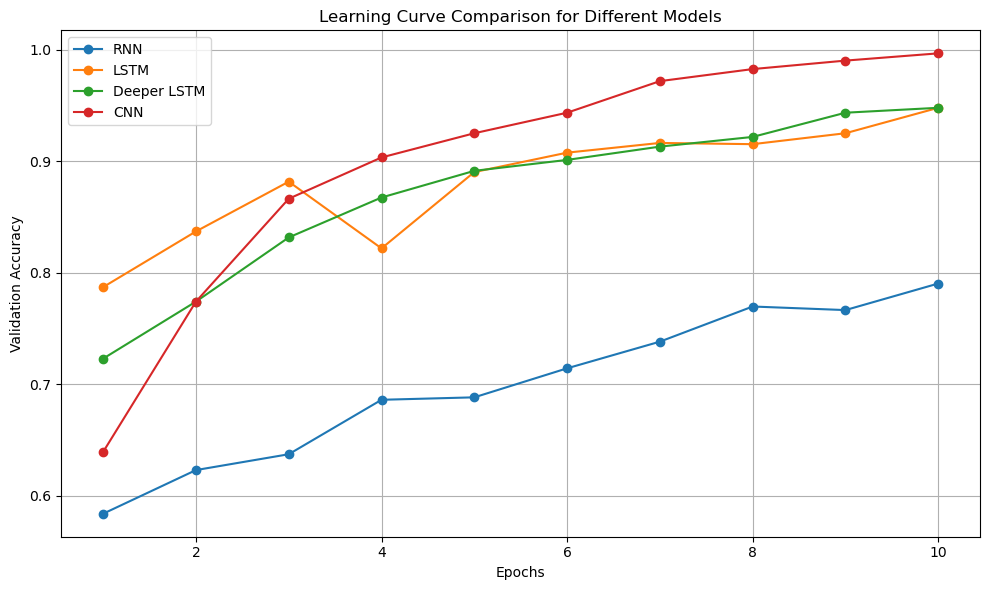

In [69]:
import matplotlib.pyplot as plt

# Validation accuracy values for each epoch
rnn_val_accuracy = [0.5841, 0.6232, 0.6374, 0.6862, 0.6884, 0.7144, 0.7383, 0.7698, 0.7666, 0.7904]
lstm_val_accuracy = [0.7872, 0.8371, 0.8817, 0.8219, 0.8903, 0.9077, 0.9164, 0.9153, 0.9251, 0.9479]
lstm2_val_accuracy = [0.7231, 0.7742, 0.8317, 0.8675, 0.8914, 0.9012, 0.9131, 0.9218, 0.9435, 0.9479]
cnn_val_accuracy = [0.6395, 0.7742, 0.8664, 0.9034, 0.9251, 0.9435, 0.9718, 0.9826, 0.9902, 0.9967]

# Number of epochs
epochs = range(1, 11)

# Plot the learning curve graphs
plt.figure(figsize=(10, 6))
plt.plot(epochs, rnn_val_accuracy, marker='o', label='RNN')
plt.plot(epochs, lstm_val_accuracy, marker='o', label='LSTM')
plt.plot(epochs, lstm2_val_accuracy, marker='o', label='Deeper LSTM')
plt.plot(epochs, cnn_val_accuracy, marker='o', label='CNN')
plt.title('Learning Curve Comparison for Different Models')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Display the graph
plt.show()


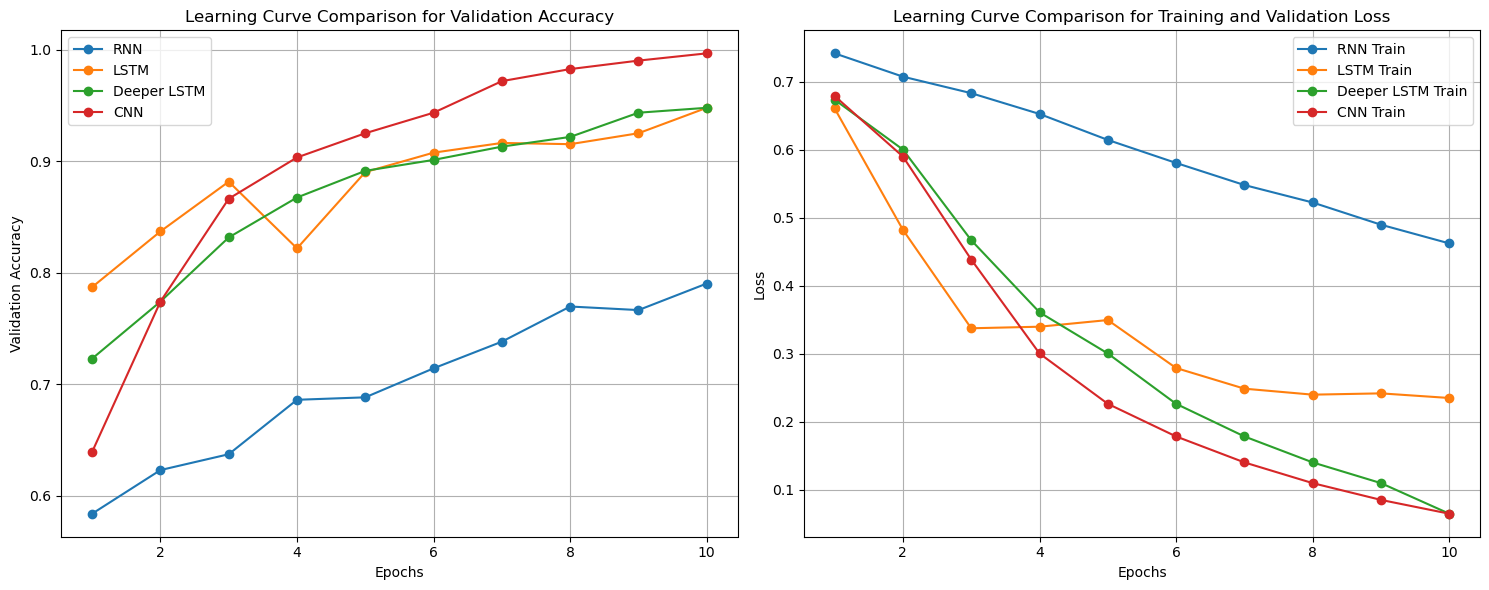

In [70]:
import matplotlib.pyplot as plt

# Validation accuracy values for each epoch
rnn_val_accuracy = [0.5841, 0.6232, 0.6374, 0.6862, 0.6884, 0.7144, 0.7383, 0.7698, 0.7666, 0.7904]
lstm_val_accuracy = [0.7872, 0.8371, 0.8817, 0.8219, 0.8903, 0.9077, 0.9164, 0.9153, 0.9251, 0.9479]
lstm2_val_accuracy = [0.7231, 0.7742, 0.8317, 0.8675, 0.8914, 0.9012, 0.9131, 0.9218, 0.9435, 0.9479]
cnn_val_accuracy = [0.6395, 0.7742, 0.8664, 0.9034, 0.9251, 0.9435, 0.9718, 0.9826, 0.9902, 0.9967]

# Training and validation loss values for each epoch
rnn_train_loss = [0.7421, 0.7078, 0.6835, 0.6529, 0.6147, 0.5808, 0.5483, 0.5226, 0.4899, 0.4624]
lstm_train_loss = [0.6610, 0.4824, 0.3375, 0.3398, 0.3496, 0.2790, 0.2486, 0.2398, 0.2417, 0.2349]
lstm2_train_loss = [0.6738, 0.6005, 0.4671, 0.3610, 0.3004, 0.2263, 0.1783, 0.1401, 0.1096, 0.0646]
cnn_train_loss = [0.6793, 0.5902, 0.4387, 0.3004, 0.2263, 0.1783, 0.1401, 0.1096, 0.0849, 0.0646]

# Number of epochs
epochs = range(1, 11)

# Create subplots for accuracy and loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot learning curve for validation accuracy
ax1.plot(epochs, rnn_val_accuracy, marker='o', label='RNN')
ax1.plot(epochs, lstm_val_accuracy, marker='o', label='LSTM')
ax1.plot(epochs, lstm2_val_accuracy, marker='o', label='Deeper LSTM')
ax1.plot(epochs, cnn_val_accuracy, marker='o', label='CNN')
ax1.set_title('Learning Curve Comparison for Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Validation Accuracy')
ax1.legend()
ax1.grid(True)

# Plot learning curve for training and validation loss
ax2.plot(epochs, rnn_train_loss, marker='o', label='RNN Train')
ax2.plot(epochs, lstm_train_loss, marker='o', label='LSTM Train')
ax2.plot(epochs, lstm2_train_loss, marker='o', label='Deeper LSTM Train')
ax2.plot(epochs, cnn_train_loss, marker='o', label='CNN Train')
ax2.set_title('Learning Curve Comparison for Training and Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


29/29 [==============================] - 1s 22ms/step


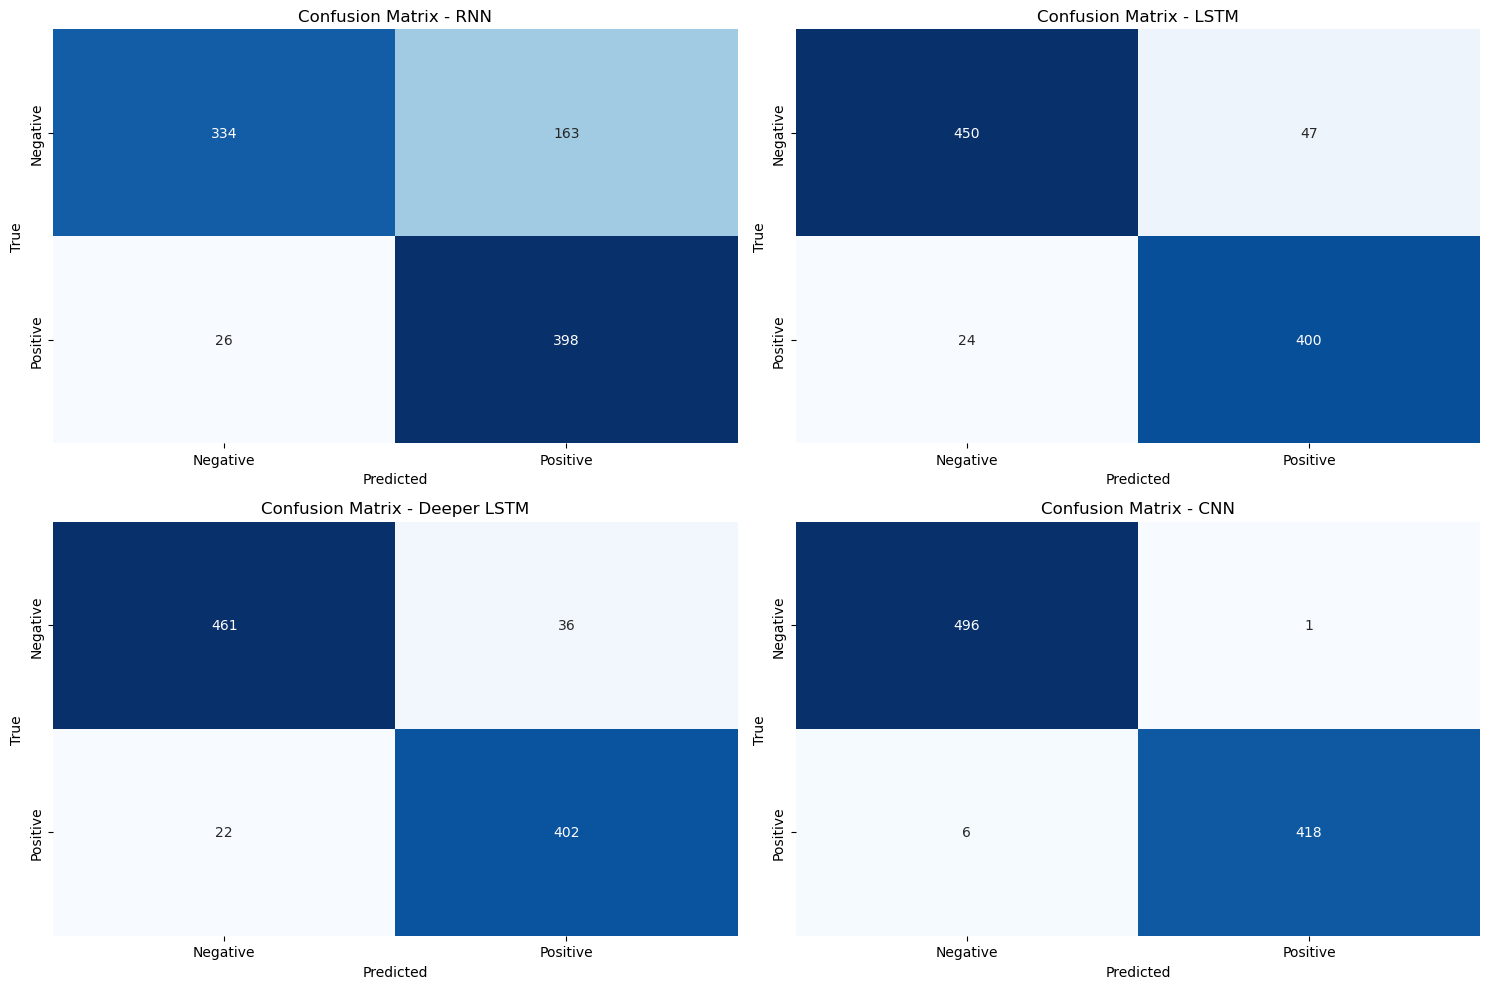

In [74]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Define the model names
model_names = ['RNN', 'LSTM', 'Deeper LSTM', 'CNN']

# Define the true labels for each model
true_labels = [y_test, y_test, y_test, y_test]

# Get predicted probabilities for each model
predicted_probs = [rnn_model.predict(X_test), lstm_model.predict(X_test),
                   lstm2_model.predict(X_test), cnn_model.predict(X_test)]

# Convert predicted probabilities to binary labels for each model
predicted_labels = []
for probs in predicted_probs:
    labels = [1 if prob > 0.5 else 0 for prob in probs]
    predicted_labels.append(labels)

# Plot confusion matrices for each model
plt.figure(figsize=(15, 10))
for i in range(4):
    plt.subplot(2, 2, i+1)
    cm = confusion_matrix(true_labels[i], predicted_labels[i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title(f'Confusion Matrix - {model_names[i]}')
    plt.xlabel('Predicted')
    plt.ylabel('True')

plt.tight_layout()
plt.show()


29/29 [==============================] - 1s 22ms/step


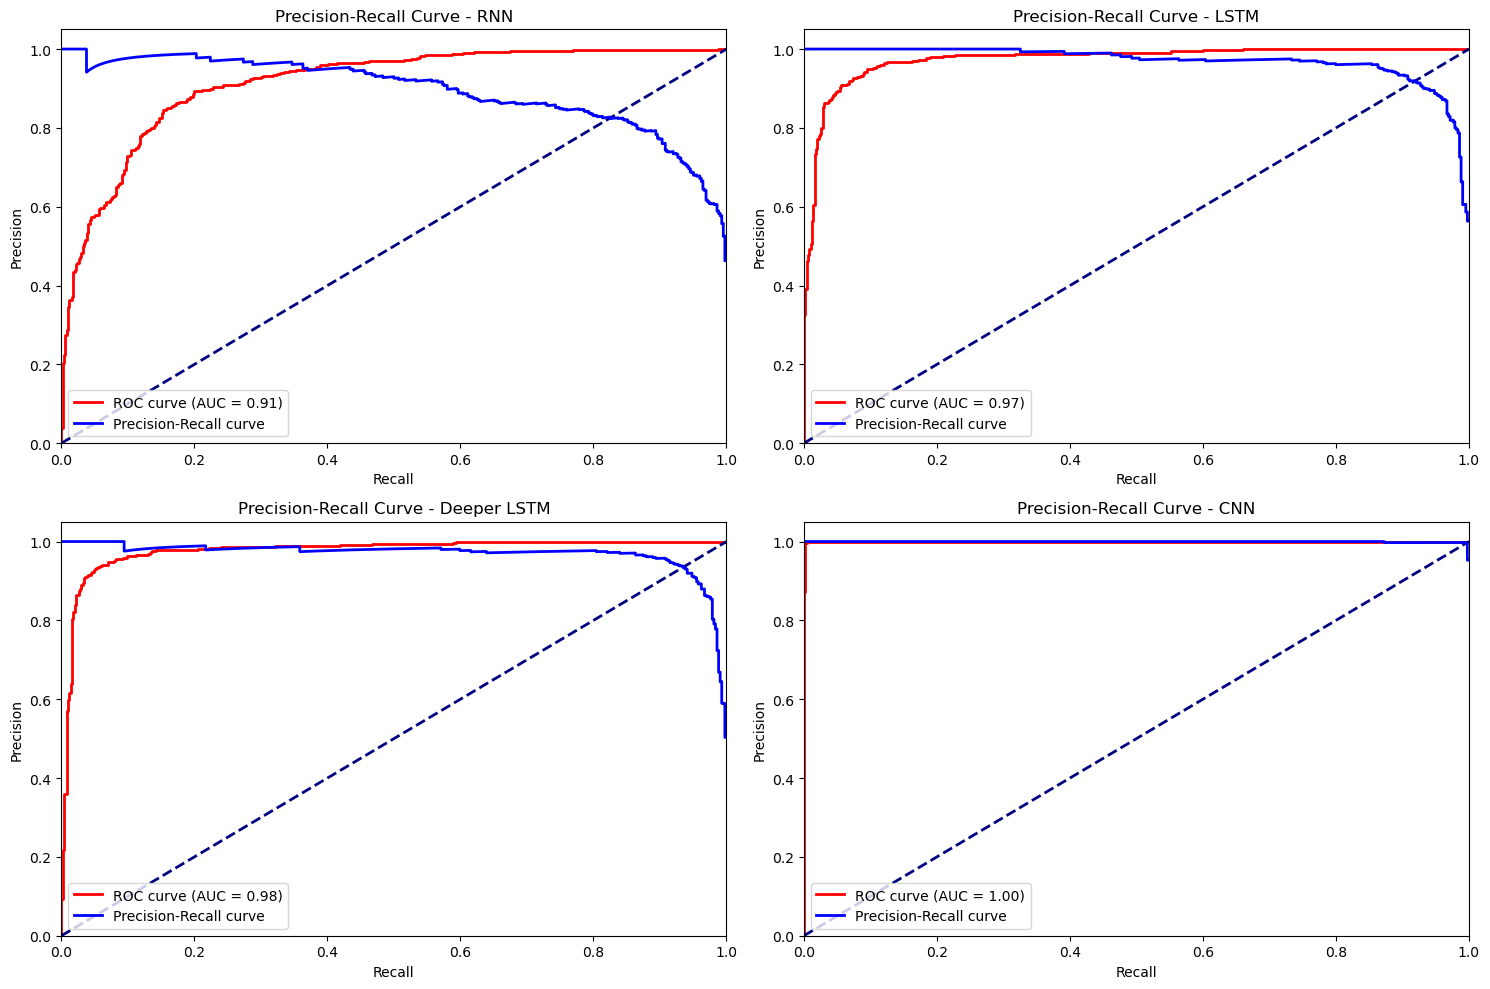

In [77]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Define the model names
model_names = ['RNN', 'LSTM', 'Deeper LSTM', 'CNN']

# Get predicted probabilities for each model
predicted_probs = [rnn_model.predict(X_test), lstm_model.predict(X_test),
                   lstm2_model.predict(X_test), cnn_model.predict(X_test)]

# Plot ROC and Precision-Recall curves for each model
plt.figure(figsize=(15, 10))
for i in range(4):
    plt.subplot(2, 2, i+1)
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, predicted_probs[i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_names[i]}')
    plt.legend(loc='lower right')
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, predicted_probs[i])
    plt.subplot(2, 2, i+1)  
    plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f'Precision-Recall Curve - {model_names[i]}')
    plt.legend(loc='lower left')

plt.tight_layout()
plt.show()


In [78]:
!pip install wordcloud


Defaulting to user installation because normal site-packages is not writeable
     -------------------------------------- 153.3/153.3 kB 1.3 MB/s eta 0:00:00


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


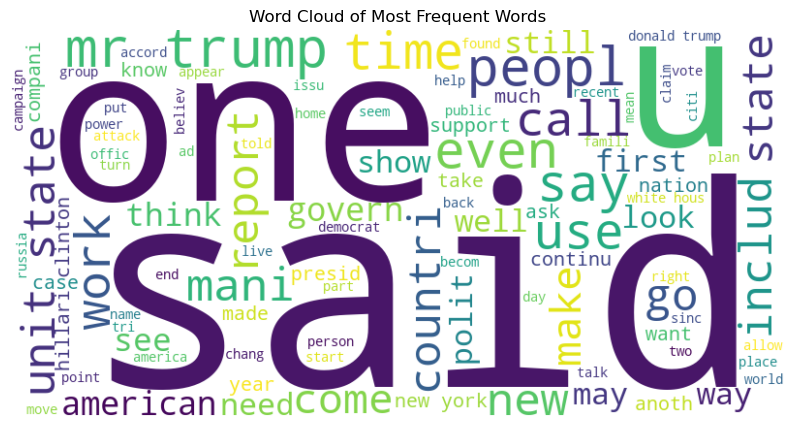

In [79]:
from wordcloud import WordCloud

# Combine all text data into a single string
all_text = ' '.join(corpus)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(all_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Frequent Words')
plt.show()
